<a href="https://colab.research.google.com/github/ProfAI/machine-learning-modelli-e-algoritmi/blob/main/7%20-%20Decision%20Tree%20e%20Random%20Forest/tree_forest_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chi si poteva salvare dal disastro del Titanic?
Per questa esercitazione dovrai prevedere la probabilità di un determinato individuo di salvarsi dal disastro del Titanic.

Per farlo puoi utilizzare il dataset che trovi [qui](https://github.com/ProfAI/machine-learning-modelli-e-algoritmi/blob/main/datasets/titanic.csv).

Il dataset contiene le seguenti informazioni:

- **passengerid**: codice identificativo del passeggero
- **name**: nome del passeggero
- **survival**: è sopravvissuto? 0=No 1=Sì
- **pclass**: 1=prima classe, 2=seconda classe, 3=terza classe
- **sex**: sesso dell'individuo male, female
- **Age**: età
- **sibsp**: numero di fratelli/sorelle/coniugi a bordo
- **parchj**: numero di parenti/figli a bordo
- **ticket**: numero del biglietto
- **fare**: tariffa del biglietto
- **cabin**: numero della cabina
- **embarked** porto di partenza C=Cherbourg, Q=Queenstown, S=Southampton

Dopo aver processato adeguatamente i dati svolgi le seguenti task:
1. Addestra un decision tree e visualizzalo
2. Se c'è overfitting prova a ridurlo utilizzando il pruning e visualizza il nuovo decision tree
3. Addestra un RandomForest cercando il numero di alberi ottimale
4. Utilizza il modello che ha performato meglio per prevedere se tu saresti sopravvissuto/a

### Importiamo i moduli

In [143]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import export_graphviz
from IPython.display import Image, display
import graphviz

### Definiamo le costanti

In [144]:
BASE_URL = "https://raw.githubusercontent.com/ProfAI/machine-learning-modelli-e-algoritmi/main/datasets/"
RANDOM_SEED = 0

### Definiamo le funzioni

In [145]:
def classifier_report(model, data):
  X, y = data
  y_pred = model.predict(X)
  report = classification_report(y, y_pred)
  print(report)
  print(confusion_matrix(y, y_pred))

def tree_viz(tree, feature_names=None, class_names=None):
  dot_data = export_graphviz(tree, out_file=None,
                        feature_names=feature_names,
                        class_names=class_names,
                        filled=True, rounded=True,
                        special_characters=True)
  graph = graphviz.Source(dot_data, filename="tree", format="png")
  graph.view()
  display(Image("tree.png"))

### Carichiamo il dataset

In [146]:
df = pd.read_csv(BASE_URL+"titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [148]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Preprocessing dei dati

In [149]:
from sklearn import set_config
set_config(transform_output="pandas")

In [150]:
df = df.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis=1)

In [151]:
X = df.drop("Survived", axis=1)
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED)
X_train.shape

(712, 7)

In [152]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
140,3,female,NaN,0,2,15.2458,C
439,2,male,31.0,0,0,10.5000,S
817,2,male,31.0,1,1,37.0042,C
378,3,male,20.0,0,0,4.0125,C
491,3,male,21.0,0,0,7.2500,S


In [153]:
#le = LabelEncoder()
#X_train["Embarked"] = le.fit_transform(X_train["Embarked"])
#X_test["Embarked"] = le.fit_transform(X_test["Embarked"])

In [154]:
import numpy as np

dict_map = {"C":0, "Q":1, "S":2}

def label_encoder(x):
  if x is np.nan:
    return x
  return dict_map[x]

X_train["Embarked"] = X_train["Embarked"].apply(label_encoder)
X_test["Embarked"] = X_test["Embarked"].apply(label_encoder)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
140,3,female,NaN,0,2,15.2458,0.0
439,2,male,31.0,0,0,10.5000,2.0
817,2,male,31.0,1,1,37.0042,0.0
378,3,male,20.0,0,0,4.0125,0.0
491,3,male,21.0,0,0,7.2500,2.0


In [155]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 140 to 684
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    object 
 2   Age       571 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  710 non-null    float64
dtypes: float64(3), int64(3), object(1)
memory usage: 44.5+ KB


In [156]:
transf = ColumnTransformer([('imputer', SimpleImputer(strategy="median"), [2, 6])], remainder="passthrough", verbose_feature_names_out=False)
X_train = transf.fit_transform(X_train)
X_test = transf.transform(X_test)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 140 to 684
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       712 non-null    float64
 1   Embarked  712 non-null    float64
 2   Pclass    712 non-null    int64  
 3   Sex       712 non-null    object 
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
dtypes: float64(3), int64(3), object(1)
memory usage: 44.5+ KB


In [157]:
transf = ColumnTransformer([('ohe', OneHotEncoder(sparse_output=False), [1])], remainder="passthrough", verbose_feature_names_out=False)
X_train = transf.fit_transform(X_train)
X_test = transf.transform(X_test)
X_train.head()

,Embarked_0.0,Embarked_1.0,Embarked_2.0,Age,Pclass,Sex,SibSp,Parch,Fare
140,1.0,0.0,0.0,29.0,3,female,0,2,15.2458
439,0.0,0.0,1.0,31.0,2,male,0,0,10.5000
817,1.0,0.0,0.0,31.0,2,male,1,1,37.0042
378,1.0,0.0,0.0,20.0,3,male,0,0,4.0125
491,0.0,0.0,1.0,21.0,3,male,0,0,7.2500


In [158]:
le = LabelEncoder()
X_train["Sex"] = le.fit_transform(X_train["Sex"])
X_test["Sex"] = le.fit_transform(X_test["Sex"])
X_train.head()

,Embarked_0.0,Embarked_1.0,Embarked_2.0,Age,Pclass,Sex,SibSp,Parch,Fare
140,1.0,0.0,0.0,29.0,3,0,0,2,15.2458
439,0.0,0.0,1.0,31.0,2,1,0,0,10.5000
817,1.0,0.0,0.0,31.0,2,1,1,1,37.0042
378,1.0,0.0,0.0,20.0,3,1,0,0,4.0125
491,0.0,0.0,1.0,21.0,3,1,0,0,7.2500


### Addestriamo l'albero

In [159]:
tree = DecisionTreeClassifier(random_state=RANDOM_SEED)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.770949720670391

In [160]:
classifier_report(tree, (X_train, y_train))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       439
           1       1.00      0.94      0.97       273

    accuracy                           0.98       712
   macro avg       0.98      0.97      0.98       712
weighted avg       0.98      0.98      0.98       712

[[439   0]
 [ 16 257]]


In [161]:
classifier_report(tree, (X_test, y_test))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       110
           1       0.72      0.67      0.69        69

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.77      0.77      0.77       179

[[92 18]
 [23 46]]


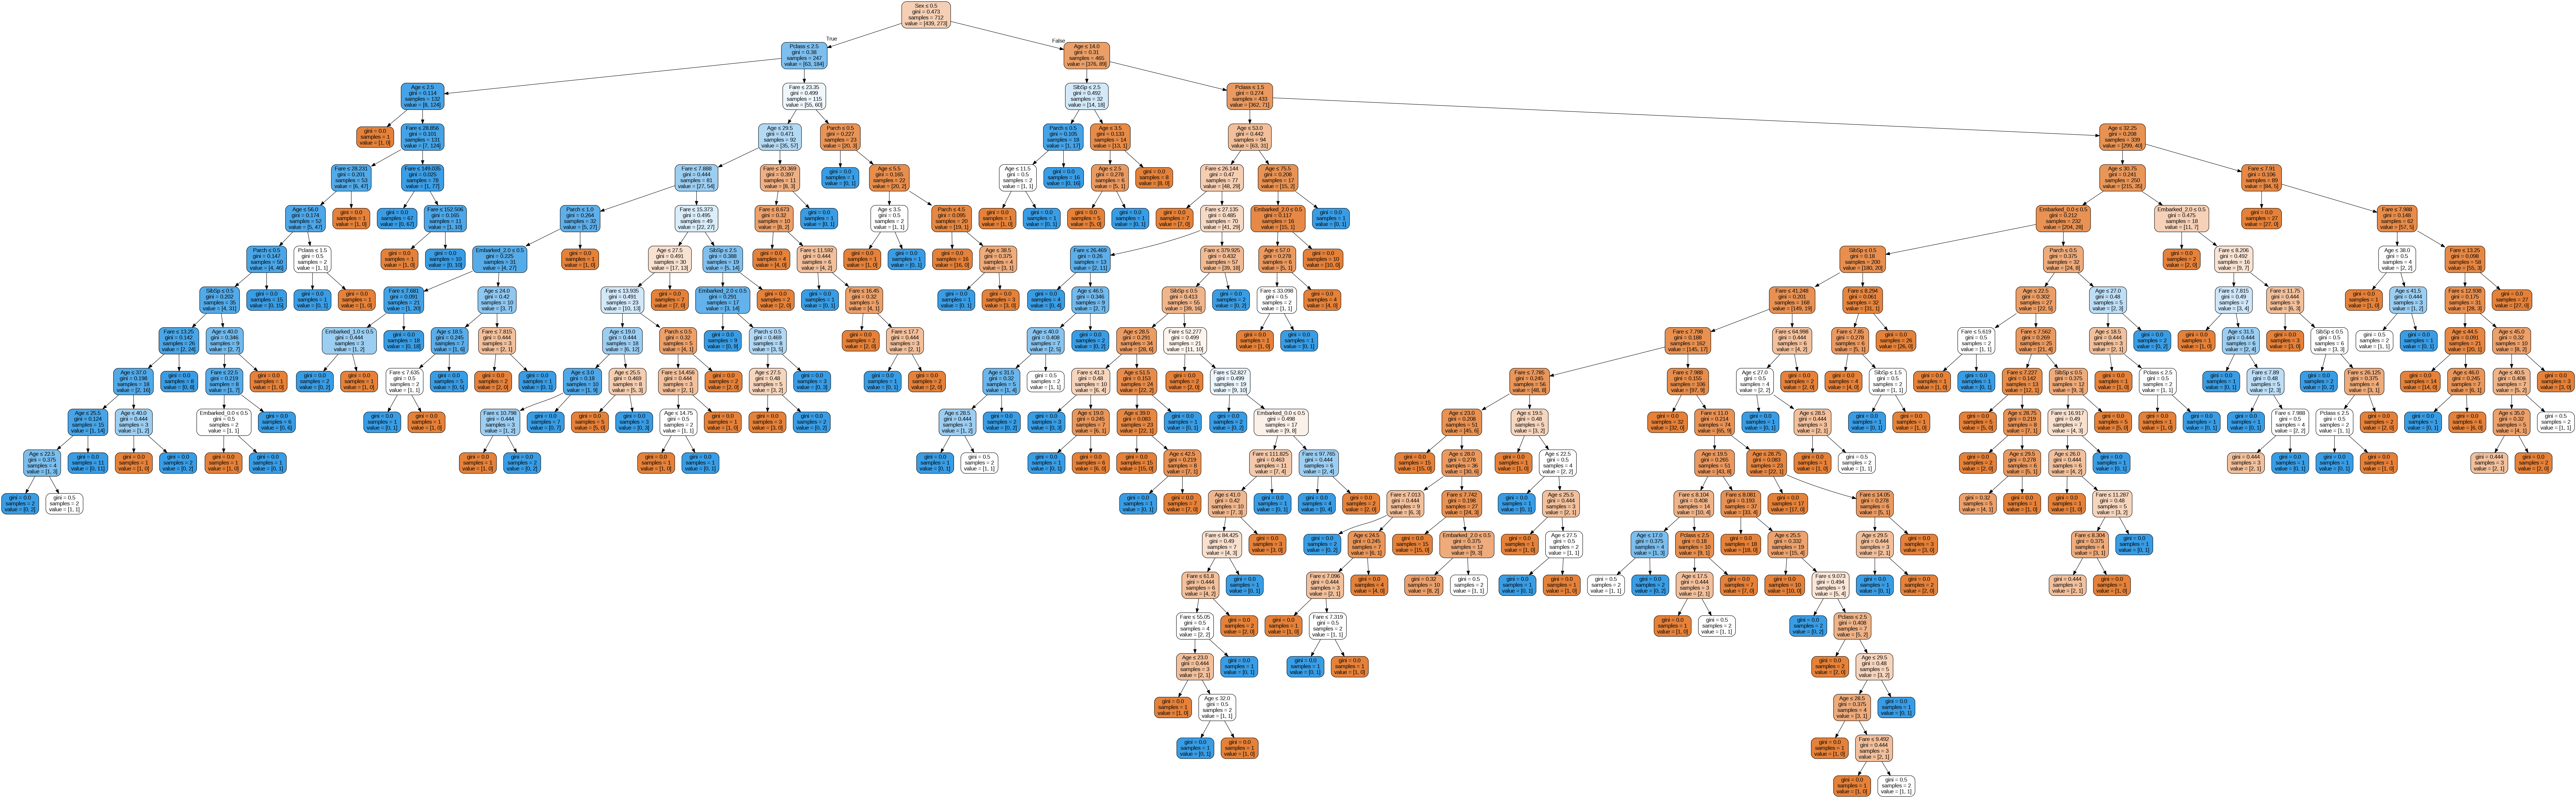

In [162]:
tree_viz(tree, feature_names=X_train.columns.values)

#### Pruning

In [163]:
tree = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=10, min_samples_leaf=5) # min_impurity_decrease=.05, ccp_alpha=0.1
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.8379888268156425

In [164]:
classifier_report(tree, (X_train, y_train))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       439
           1       0.90      0.77      0.83       273

    accuracy                           0.88       712
   macro avg       0.88      0.86      0.87       712
weighted avg       0.88      0.88      0.88       712

[[415  24]
 [ 62 211]]


In [165]:
classifier_report(tree, (X_test, y_test))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       110
           1       0.86      0.70      0.77        69

    accuracy                           0.84       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.84      0.84      0.83       179

[[102   8]
 [ 21  48]]


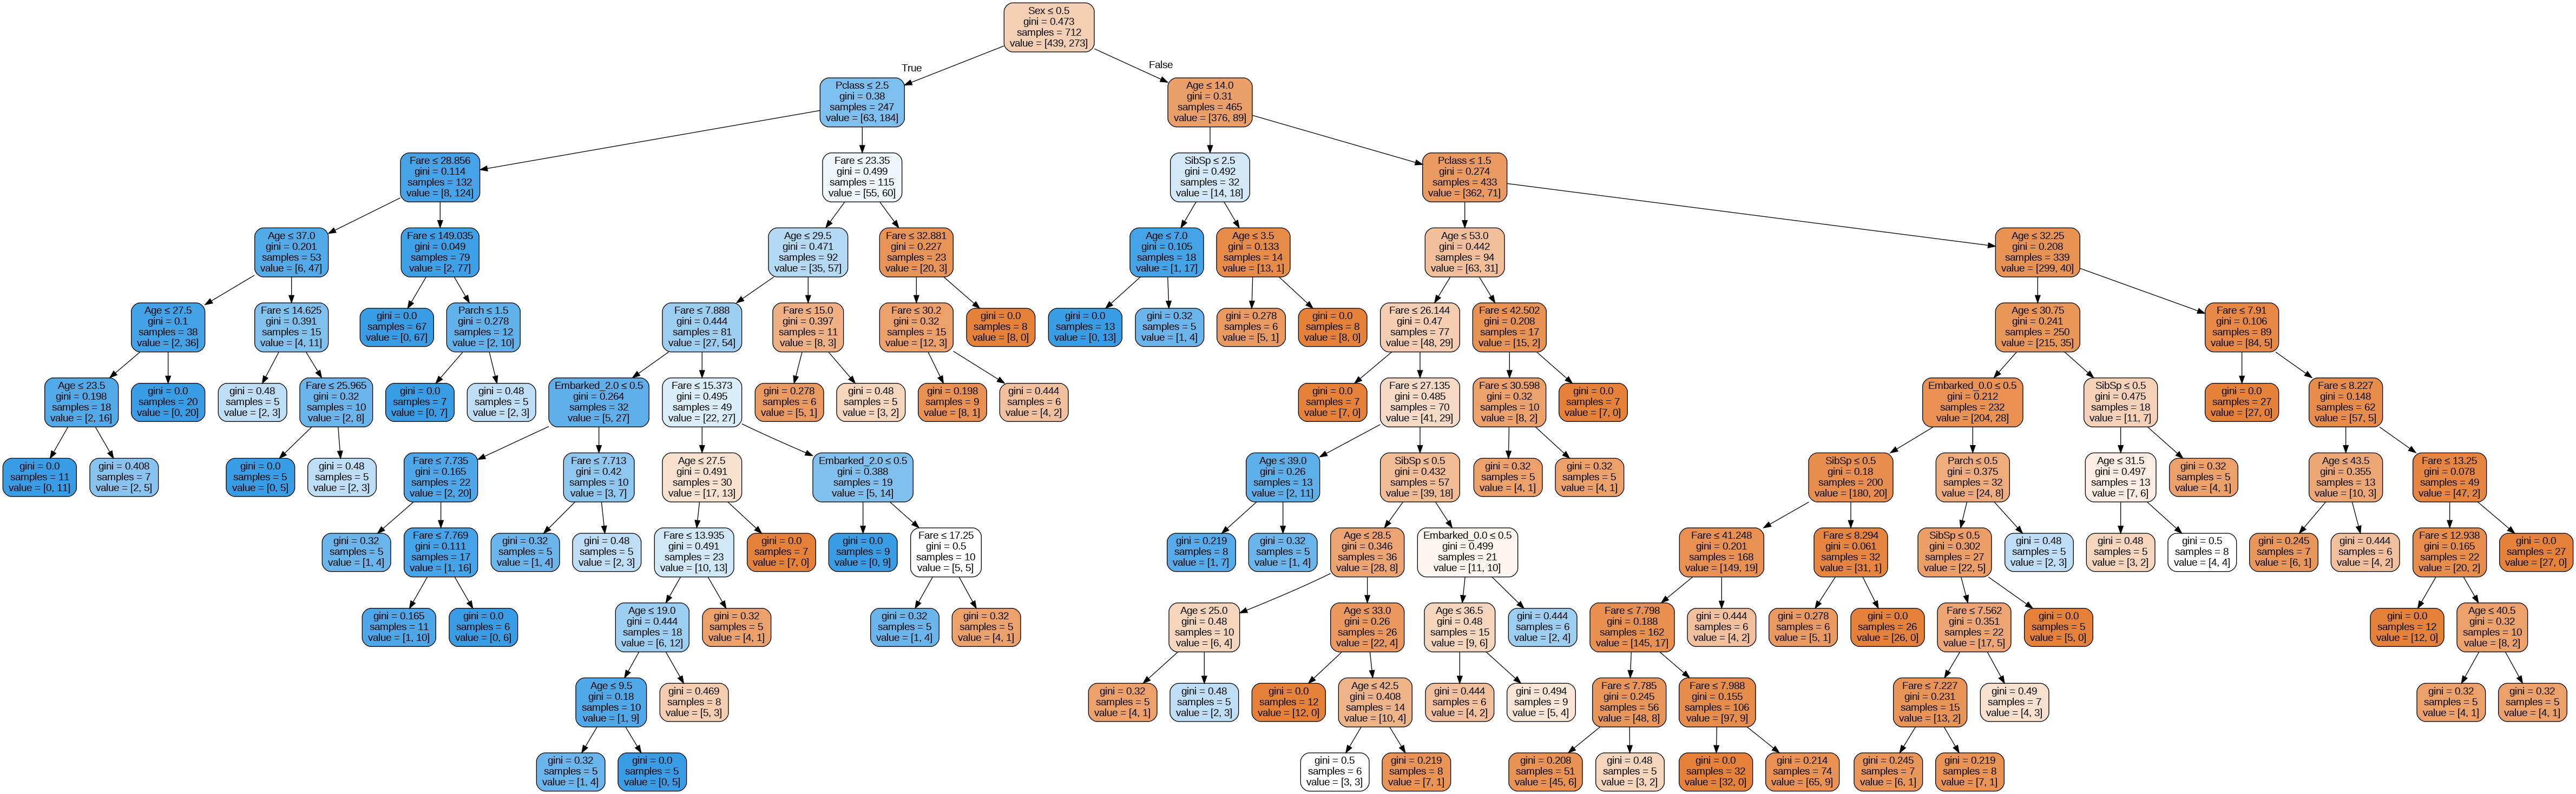

In [166]:
tree_viz(tree, feature_names=X_train.columns.values)

### Addestriamo la foresta

In [169]:
for n_tree in [1, 2, 3, 5, 10, 20, 50, 100, 500, 1000]:
  print(f"Addestramento di una foresta con {n_tree} alberi...")
  forest = RandomForestClassifier(n_tree, random_state=RANDOM_SEED, max_depth=10, min_samples_leaf=5)
  forest.fit(X_train, y_train)
  print(f"Accuracy: Train={forest.score(X_train, y_train):.3f} Test={forest.score(X_test, y_test):.3f}")

Addestramento di una foresta con 1 alberi...
Accuracy: Train=0.798 Test=0.782
Addestramento di una foresta con 2 alberi...
Accuracy: Train=0.823 Test=0.788
Addestramento di una foresta con 3 alberi...
Accuracy: Train=0.853 Test=0.799
Addestramento di una foresta con 5 alberi...
Accuracy: Train=0.841 Test=0.804
Addestramento di una foresta con 10 alberi...
Accuracy: Train=0.855 Test=0.816
Addestramento di una foresta con 20 alberi...
Accuracy: Train=0.872 Test=0.838
Addestramento di una foresta con 50 alberi...
Accuracy: Train=0.871 Test=0.832
Addestramento di una foresta con 100 alberi...
Accuracy: Train=0.868 Test=0.827
Addestramento di una foresta con 500 alberi...
Accuracy: Train=0.865 Test=0.844
Addestramento di una foresta con 1000 alberi...
Accuracy: Train=0.868 Test=0.844


In [182]:
forest = RandomForestClassifier(500, random_state=RANDOM_SEED, max_depth=10, min_samples_leaf=5)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=500,
                       random_state=0)

### Sarei sopravvissuto?

In [185]:
x = {"Pclass":[1], "Sex":["male"],	"Age":[30],	"SibSp":[0],	"Parch":[0],	"Fare":[50],	"Embarked":["C"]}
x = pd.DataFrame.from_dict(x)
x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,30,0,0,5,C


In [186]:
x["Embarked"] = x["Embarked"].apply(label_encoder)
x = transf.transform(x)
x["Sex"] = le.transform(x["Sex"])

x.head()

,Embarked_0.0,Embarked_1.0,Embarked_2.0,Age,Pclass,Sex,SibSp,Parch,Fare
0,1.0,0.0,0.0,30,3,1,0,0,5


In [187]:
forest.predict_proba(x)

array([[0.88987878, 0.11012122]])